# Data cleaning

### Loading data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

#Import
data = pd.read_csv('dataset_mood_smartphone.csv')

data 
#Convert time column to date time format
data['time']= pd.to_datetime(data['time']) 
data

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
5,6,AS14.01,2014-02-27 12:00:00.000,mood,6.000
6,7,AS14.01,2014-02-27 15:00:00.000,mood,7.000
7,8,AS14.01,2014-03-21 09:00:00.000,mood,6.000
8,9,AS14.01,2014-03-21 11:00:00.000,mood,6.000
9,10,AS14.01,2014-03-21 15:00:00.000,mood,7.000


### Changing to multi index with time and ID

In [9]:
data = data.set_index(['id', 'time'])

We want to reformat the data such that we have a number of observations for each patient, with each observation consisting of some time period e.g one week. Each observation will have a measurement for each attribute (e.g., Avg time spent on weather app over period) with the dependent variable as the average mood over the period. 

In [10]:
#reshaping the dataframe so that each column is a feature, indexed first by patient then time
data2 = pd.pivot_table(data, index=['id', 'time'], columns='variable', values='value')
data2

variable                         activity  appCat.builtin  \
id      time                                                
AS14.01 2014-02-17 12:04:42.394       NaN             NaN   
        2014-02-17 18:28:25.520       NaN             NaN   
        2014-02-18 09:29:51.257       NaN             NaN   
        2014-02-19 14:43:30.575       NaN             NaN   
        2014-02-19 17:29:10.378       NaN             NaN   
        2014-02-19 17:42:16.499       NaN             NaN   
        2014-02-19 17:42:34.292       NaN             NaN   
        2014-02-19 17:43:18.061       NaN             NaN   
        2014-02-19 17:44:01.594       NaN             NaN   
        2014-02-19 18:07:50.055       NaN             NaN   
        2014-02-19 18:10:06.385       NaN             NaN   
        2014-02-19 21:25:04.397       NaN             NaN   
        2014-02-20 10:58:33.924       NaN             NaN   
        2014-02-20 11:13:44.448       NaN             NaN   
        2014-02-20 11:16:45.930       NaN             NaN   
        2014-02-20 13:42:05.309       NaN             NaN   
        2014-02-20 13:42:56.997       NaN             NaN   
        2014-02-21 15:36:58.253       NaN             NaN   
        2014-02-22 17:34:44.325       NaN             NaN   
        2014-02-22 18:17:55.618       NaN             NaN   
        2014-02-22 22:32:39.631       NaN             NaN   
        2014-02-25 11:27:52.973       NaN             NaN   
        2014-02-25 11:38:26.127       NaN             NaN   
        2014-02-25 12:29:25.009       NaN             NaN   
        2014-02-26 13:00:00.000       NaN             NaN   
        2014-02-26 15:00:00.000       NaN             NaN   
        2014-02-26 16:19:04.586       NaN             NaN   
        2014-02-26 18:00:00.000       NaN             NaN   
        2014-02-26 18:10:37.734       NaN             NaN   
        2014-02-26 21:00:00.000       NaN             NaN   
...                                   ...             ...   
AS14.33 2014-05-30 21:58:51.395       NaN           3.018   
        2014-05-30 21:58:54.421       NaN             NaN   
        2014-05-30 21:59:57.865       NaN          21.075   
        2014-05-30 22:00:00.000     0.375             NaN   
        2014-05-30 22:00:18.943       NaN          72.213   
        2014-05-30 22:01:31.157       NaN           1.016   
        2014-05-30 22:01:32.177       NaN           3.019   
        2014-05-30 22:01:35.197       NaN          25.076   
        2014-05-30 22:02:00.275       NaN             NaN   
        2014-05-30 22:02:24.378       NaN          23.085   
        2014-05-30 22:02:47.464       NaN          27.386   
        2014-05-30 22:03:14.875       NaN           4.016   
        2014-05-30 22:03:19.157       NaN          13.045   
        2014-05-30 22:03:32.207       NaN           2.004   
        2014-05-30 22:03:34.213       NaN          47.219   
        2014-05-30 22:04:21.434       NaN           7.018   
        2014-05-30 22:04:28.453       NaN             NaN   
        2014-05-30 22:04:31.486       NaN          22.076   
        2014-05-30 22:04:53.562       NaN          71.257   
        2014-05-30 22:06:04.821       NaN           3.005   
        2014-05-30 22:06:07.826       NaN             NaN   
        2014-05-30 22:07:36.256       NaN           1.266   
        2014-05-30 22:18:11.591       NaN             NaN   
        2014-05-30 22:31:07.964       NaN             NaN   
        2014-05-30 22:32:00.898       NaN           4.072   
        2014-05-30 22:32:05.016       NaN             NaN   
        2014-05-30 22:32:11.049       NaN           3.122   
        2014-05-30 22:32:14.240       NaN           1.003   
        2014-05-30 22:32:15.246       NaN           4.134   
        2014-05-31 12:00:00.000       NaN             NaN   

variable                         appCat.communication  appCat.entertainment  \
id      time                                                                 

### Aggregating the data into time windows 

For all of the apps, sms and calls we take the sum over the windows, since they are either times spent or number of calls etc. For arousal, mood and valence we take the mean.

In [ ]:
prev_index = 0
for row in data2:
    
    if data2.iloc[[0]]['mood'] > 0:



In [4]:
#This is currently grouping observations into 2 day windows, can make a decision on this later

data2 = data2.astype(float)
data2 = data2.groupby([pd.Grouper(level='id'), pd.Grouper(freq='2D', level='time') 
                             ]).agg({'activity': 'sum', 'appCat.builtin':'sum',
                                                           'appCat.communication':'sum', 'appCat.entertainment':'sum',
                                                           'appCat.finance':'sum', 'appCat.game':'sum', 'appCat.office':'sum',
                                                           'appCat.other':'sum', 'appCat.social':'sum', 'appCat.travel':'sum',
                                                           'appCat.unknown':'sum', 'appCat.utilities':'sum', 'appCat.weather':'sum',
                                                           'call':'sum', 'screen':'sum', 'sms':'sum','circumplex.valence':'mean',
                                                           'circumplex.arousal':'mean', 'mood':'mean'})

### Compile the data into mood measurements 
It seems like im loosing some of the starting bits of the data here.  Im a  bit confused as to why.... It might be that id doesnt exist for the other index other than the first.  This needs to be explored.  

In [24]:
#Make copy of data
data3 = copy.deepcopy(data2)

#Setup new frame
df = pd.DataFrame(columns=data3.columns)

df.insert(0,'date', "")
df.insert(0,'id', "")
df_lost = copy.deepcopy(df)

prev_id = data3.index[0][0]
i_prev = 0
ave_list = ['circumplex.arousal', 'mood', 'circumplex.valence']

tmp = []
for i in range(0, len(data3)):
    if data3.index[i][0] != prev_id:
        for k in range(i_prev, i):
            tmp.append(data3.index[i_prev][0])
            tmp.append(data3.index[k][1])
            for j in range(0, len(data3.columns)):
                tmp.append(data3.iloc[k,j])
            #print(len(tmp))
            df_lost.loc[len(df_lost)] = tmp
            tmp = []
        i_prev = i
        prev_id = data3.index[i][0]
    if not pd.isnull(data3['mood'].iloc[i]):
        tmp.append(data3.index[i_prev][0])
        tmp.append(data3.index[i][1])
        for j in range(0, len(data3.columns)):
            if any(data3.columns[j] in s for s in ave_list):
                tmp.append(data3.iloc[i_prev:i+1,j].mean())
            else:
                tmp.append(data3.iloc[i_prev:i+1,j].sum())
        df.loc[len(df)] = tmp
        tmp = []
        i_prev = i+1
df

AttributeError: 'list' object has no attribute 'contains'

### Removing observations/days without mood measurements

In [5]:
data2 = data2.dropna(subset=['mood'])

### Dropping columns with little data

In [6]:
data2 = data2.drop(columns=['appCat.finance','appCat.game', 'appCat.unknown', 'appCat.weather'])

### Remove outliers

It is clear from the plots that there are some outliers that are nonsensical. No values should be negative apart from those for arousal or valence, which have a minimum value of -2. Therefore a good starting point is to remove any values which are less than that for the whole dataframe.

In [7]:
from scipy import stats

data2 = data2.astype(float)
data2 = data2[(np.abs(stats.zscore(data2)) < 4).all(axis=1)]

### Instead aggregating data into windows up to each mood measurement 

In [ ]:
test = data2.groupby(['id', 'time', 'mood'])

test.head()

In [ ]:
#This will give us more observations that grouping by day

data2 = data2.groupby([pd.Grouper(freq='1D', level='time'), 
                             pd.Grouper(level='id')]).agg({'activity': 'sum', 'appCat.builtin':'sum',
                                                           'appCat.communication':'sum', 'appCat.entertainment':'sum',
                                                           'appCat.finance':'sum', 'appCat.game':'sum', 'appCat.office':'sum',
                                                           'appCat.other':'sum', 'appCat.social':'sum', 'appCat.travel':'sum',
                                                           'appCat.unknown':'sum', 'appCat.utilities':'sum', 'appCat.weather':'sum',
                                                           'call':'sum', 'screen':'sum', 'sms':'sum','circumplex.valence':'mean',
                                                           'circumplex.arousal':'mean', 'mood':'mean'})

# Exploration

### Mood distribution 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f731b9dd0>]],
      dtype=object)

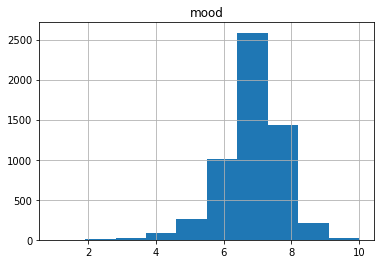

In [6]:
#We can now look at the distributions for each variable
data2.hist('mood')

### Observation counts for each day

In [ ]:
#This tells us the number of individuals for which we have mood data for each day in the dataset
data2.groupby(level=0)['mood'].count()

It is clear that there is a narrow time period over which we have data for all patients simulatneously. We cannot do much with days for which we little or no mood data, therefore we could consider discarding data in the early and late periods.

### Observation counts for each patient 

In [ ]:
#This tells us the number of mood observations for each individual
data2.groupby(level=1)['mood'].count()

### Counts for each variable, for each patient

In [ ]:
#Number of available instances for each variable, for each patient
data2.groupby(level=1).count()

There are a number of attributes for which we have few or no measurements for many of the patients, namely: Finance, Games, office, unknown, and weather. In some of these cases they may be entirely useless, especially if they happen to be highly correlated with other variables. We could consider taking binary indicators for some of these, with the intuition that if they check finance or office apps they have assets or a job, if they check the weather app they go outside, if they play mobile games they procrastinate etc

### Pairwise plots

Looking at the number of non-zero observations in each column after the above transformations

In [ ]:
import seaborn as sns

sns.pairplot(data2.loc[:,data2.dtypes == 'float64'])

### Correlation between predictors

In [ ]:
corr_matrix = data2.corr()
corr_matrix['mood']

# Feature engineering

Here we need to create new variables to improve our predictive power

Ideas so far:
- Days of week, month of recording
- Mood swing in last week
- Mornging/evening
- Binary indicators for some ommitted apps

In the paper on this dataset they say that basically none of the apps have any predictive power - once we show this 
#ourselves we could simplify the model down immensely using principle components/ indicators for 
"uses phone a lot-or not" 

### Day of week indicators

In [8]:
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, x in enumerate(names):
    data2[x] = (data2.index.get_level_values(1).weekday == i).astype(int)
    
data2.head()


activity  appCat.builtin  appCat.communication  \
id      time                                                         
AS14.01 2014-02-25  0.000000           0.000                 0.000   
        2014-02-27  0.000000           0.000                 0.000   
        2014-03-21  6.873236        3870.647             11243.808   
        2014-03-23  4.036182        2153.202             14507.948   
        2014-03-25  4.792378        2200.265             19265.504   

                    appCat.entertainment  appCat.office  appCat.other  \
id      time                                                            
AS14.01 2014-02-25                 0.000          0.000         0.000   
        2014-02-27                 0.000          0.000         0.000   
        2014-03-21              1100.780        172.206       337.894   
        2014-03-23              1071.317          3.010       139.381   
        2014-03-25               978.685          0.000       276.317   

                    appCat.social  appCat.travel  appCat.utilities  call  ...  \
id      time                                                              ...   
AS14.01 2014-02-25          0.000          0.000             0.000   4.0  ...   
        2014-02-27          0.000          0.000             0.000   4.0  ...   
        2014-03-21       4948.132        952.750           716.375   9.0  ...   
        2014-03-23       4124.465        419.805           208.818  10.0  ...   
        2014-03-25       6511.530          0.000           256.258   0.0  ...   

                    circumplex.valence  circumplex.arousal      mood  Monday  \
id      time                                                                   
AS14.01 2014-02-25            0.750000           -0.250000  6.250000       0   
        2014-02-27            0.333333            0.000000  6.333333       0   
        2014-03-21            0.333333            0.400000  6.300000       0   
        2014-03-23            0.400000            0.500000  6.400000       0   
        2014-03-25            0.555556            0.111111  6.666667       0   

                    Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  
id      time                                                                
AS14.01 2014-02-25        1          0         0       0         0       0  
        2014-02-27        0          0         1       0         0       0  
        2014-03-21        0          0         0       1         0       0  
        2014-03-23        0          0         0       0         0       1  
        2014-03-25        1          0         0       0         0       0  

[5 rows x 22 columns]

### Month indicators

In [9]:
names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for i, x in enumerate(names):
    data2[x] = (data2.index.get_level_values(1).month == i-1).astype(int)
    
data2.head()

activity  appCat.builtin  appCat.communication  \
id      time                                                         
AS14.01 2014-02-25  0.000000           0.000                 0.000   
        2014-02-27  0.000000           0.000                 0.000   
        2014-03-21  6.873236        3870.647             11243.808   
        2014-03-23  4.036182        2153.202             14507.948   
        2014-03-25  4.792378        2200.265             19265.504   

                    appCat.entertainment  appCat.office  appCat.other  \
id      time                                                            
AS14.01 2014-02-25                 0.000          0.000         0.000   
        2014-02-27                 0.000          0.000         0.000   
        2014-03-21              1100.780        172.206       337.894   
        2014-03-23              1071.317          3.010       139.381   
        2014-03-25               978.685          0.000       276.317   

                    appCat.social  appCat.travel  appCat.utilities  call  ...  \
id      time                                                              ...   
AS14.01 2014-02-25          0.000          0.000             0.000   4.0  ...   
        2014-02-27          0.000          0.000             0.000   4.0  ...   
        2014-03-21       4948.132        952.750           716.375   9.0  ...   
        2014-03-23       4124.465        419.805           208.818  10.0  ...   
        2014-03-25       6511.530          0.000           256.258   0.0  ...   

                    March  April  May  June  July  August  September  October  \
id      time                                                                    
AS14.01 2014-02-25      0      1    0     0     0       0          0        0   
        2014-02-27      0      1    0     0     0       0          0        0   
        2014-03-21      0      0    1     0     0       0          0        0   
        2014-03-23      0      0    1     0     0       0          0        0   
        2014-03-25      0      0    1     0     0       0          0        0   

                    November  December  
id      time                            
AS14.01 2014-02-25         0         0  
        2014-02-27         0         0  
        2014-03-21         0         0  
        2014-03-23         0         0  
        2014-03-25         0         0  

[5 rows x 34 columns]

### Mood swing indicator

# OLS as first test of feature importance

In [ ]:
olsdata = data2.groupby([pd.Grouper(freq='6M', level='time'), 
                             pd.Grouper(level='id')]).agg({'activity': 'sum', 'appCat.builtin':'sum',
                                                           'appCat.communication':'sum', 'appCat.entertainment':'sum',
                                                           'appCat.finance':'sum', 'appCat.game':'sum', 'appCat.office':'sum',
                                                           'appCat.other':'sum', 'appCat.social':'sum', 'appCat.travel':'sum',
                                                           'appCat.unknown':'sum', 'appCat.utilities':'sum', 'appCat.weather':'sum',
                                                           'call':'sum', 'screen':'sum', 'sms':'sum','circumplex.valence':'mean',
                                                           'circumplex.arousal':'mean', 'mood':'mean'})
olsdata.head()

# Principle component Analysis

It's very probable that many of the apps serve similar purposes for the user and therefore may have a similar effect - a PCA could possibly decompose these features into a smaller subset representing e.g. A need for socializing (Messneger apps), boredom (News, finance)

In [ ]:
from sklearn.preprocessing import StandardScaler

#Before we can run PCA we need to standarize all of the features

features = ['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 
            'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 
            'appCat.weather', 'call', 'screen', 'sms', 'circumplex.valence', 'circumplex.arousal']
x = data2.loc[:, features].values
x = StandardScaler().fit_transform(x)

y = data2.loc[:,['mood']].values

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principalDf.head()

In [ ]:
finalDf = pd.concat([principalDf, data2[['mood']]], axis = 1)

# Mean model

# Linear regression for aggregated data

# Decision Tree/Random forrest

# Individual models (ARIMA?)